# Poisson's equation

Now extend your solver to solve for Poisson's equation.
* Consider a 64 x 64 grids in a domain ($-1<x<1$ and $-1<y<1$)
* Assume $\rho(r)= \exp(-10r)$
* Assume $u$ is zero on the four boundaries.
* Solver for the potential $u$.
* What is the corresponding electrical (or gravitational) field? (Hints: use `numpy.gradient()`)

In [1]:
import numpy as np
#from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg
from scipy import linalg
from numba import jit, njit, prange
import matplotlib.pyplot as plt

In [2]:
# Copy your Laplace's Equation solver from demo1 here
def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))
    def diaganol_four_matrix(n):
        ex = np.ones(n)
        data = np.array([ex,-4*ex,ex])
        offsets = np.array([-1,0,1])
        return -dia_matrix((data,offsets),shape=(n,n)).toarray()

    
    for i in prange(N):
        for j in prange(N):
            if i == j:
                submatrix = diaganol_four_matrix(N)
            elif abs(i-j) == 1:
                submatrix = -np.identity(N)
            else:
                submatrix = np.zeros((N,N))
        
            for ii in range(N):
                for jj in range(N):
                    A[ii+i*N,jj+j*N] = submatrix[ii,jj]
    print(f'finished{N}')
    return A

def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u



The right hand side vector need to be updated when there is a density field $\rho$.
First, we write a function `generate_rho()` to generate the $N \times N$ density field.

In [9]:
def generate_rho(N, xmin=-1, xmax=1, ymin=-1,ymax=1):
    x = np.linspace(xmin,xmax,N,endpoint=True)
    y = np.linspace(ymin,ymax,N,endpoint=True)
    xx,yy = np.meshgrid(x,y)
    rho = np.exp(-10*np.sqrt(xx**2+yy**2))
    return rho

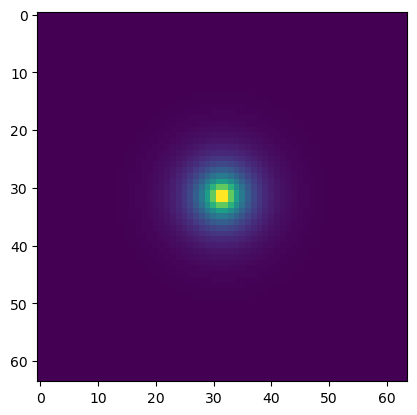

In [11]:
# Visualize the density field
rho = generate_rho(N=64)
plt.imshow(rho)

Once we have the density filed, we need to modify the `generate_the_rhs_vector_with_size()` to include the density field.

In [12]:
def generate_the_rhs_vector_with_size(N=4, rho=None, dx=1):

    if rho is None:
        b = np.zeros(N*N)
        b[-N:] = 1 
    else:
        b = rho.flatten()
        b = -b*dx**2
    return b


We could solve the system by the same way in `solve_laplace()`.

In [16]:
def solve_laplace(N=16):
    A = generate_the_laplace_matrix_with_size(N=N)
    rho = generate_rho(N=N)
    b = generate_the_rhs_vector_with_size(N=N, rho=rho, dx=2/(N-1))
    #x = linalg.solve(A,b) # use scipy
    #x = lu_solve(A,b)      # use our solver
    x = splinalg.spsolve(A,b) # use scipy sparse solver
    u = convert_solution(x)
    return u

In [19]:
u = solve_laplace(N=128)

finished128


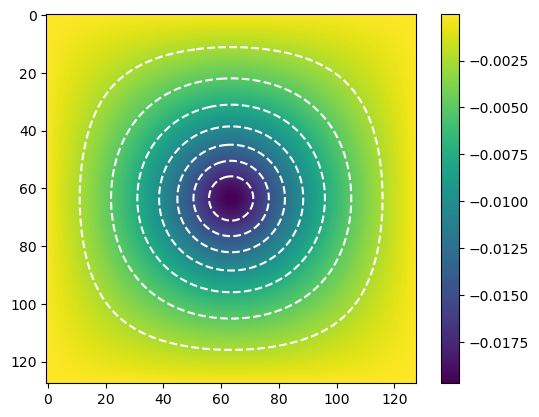

In [20]:
# Visualize the solution
plt.imshow(u)
plt.colorbar()
plt.contour(u,colors="w")

Calculate the gravitational field

In [21]:
phi =np.gradient(u)

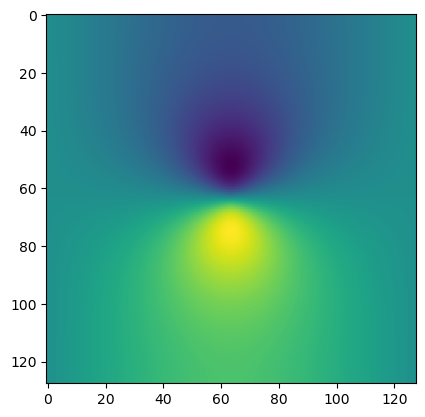

In [22]:
plt.imshow(phi[0]) # x derivative

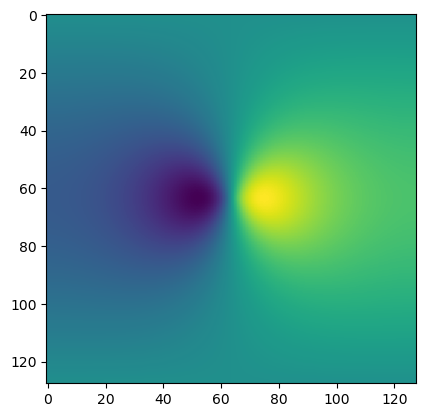

In [23]:
plt.imshow(phi[1]) # y derivative